<a href="https://colab.research.google.com/github/amar-naik/EVA/blob/master/S9/Copy_of_EVA4_S9_CIFAR10_Albumentation_GRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries

In [38]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import sys
import matplotlib.pyplot as plt
import numpy as np
import random
# from torch_receptive_field import PytorchReceptiveField

import imgaug.augmenters as iaa
from matplotlib import cm
!pip install torch torchvision
!pip install torchsummary

In [39]:
#install from Python Package Index (PyPI) 
!pip install albumentations
#latest version directly from github before released to pypi
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-3ybm6y_j
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-3ybm6y_j
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=dbc68e352d5c20f859b043273e0bc5276171290a4fa99883d5c3ce25d84ea9dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-vh9_1_m6/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


# 2. Mount Google Drive to get the files individual files

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/S9_CIFAR10_Albumentation_GRADCAM/")
!ls

'Assignment 9_Response.gdoc'		       gradCAMvisualize.py
 cifar10_data_provider.py		       images
 customDeepCNN.py			       lr_finder.py
 data					       models
 dataTorchTransformLoad.py		       __pycache__
 datatransformation.py			       testModel.py
 displayimages.py			       trainModel.py
 EVA4_S9_CIFAR10_Albumentation_GRADCAM.ipynb   train_test.py
 grad-cam.py				       traintest.py
 gradcam.py				       utils.py


In [42]:
!rm -rf '/content/drive/My Drive/Colab Notebooks/S9_CIFAR10_Albumentation_GRADCAM/__pycache__'
!ls -lrt '/content/drive/My Drive/Colab Notebooks/S9_CIFAR10_Albumentation_GRADCAM/'

total 517
-rw------- 1 root root   8232 Mar 16 20:17  grad-cam.py
-rw------- 1 root root   4047 Mar 16 21:45  customDeepCNN.py
drwx------ 3 root root   4096 Mar 16 21:47  data
-rw------- 1 root root   2747 Mar 17 18:23  testModel.py
-rw------- 1 root root   3010 Mar 17 22:05  traintest.py
-rw------- 1 root root   3535 Mar 17 22:07  cifar10_data_provider.py
drwx------ 3 root root   4096 Mar 21 20:35  models
-rw------- 1 root root 437474 Mar 21 21:51  EVA4_S9_CIFAR10_Albumentation_GRADCAM.ipynb
-rw------- 1 root root   3886 Mar 21 22:14  trainModel.py
-rw------- 1 root root   4701 Mar 21 22:41  dataTorchTransformLoad.py
-rw------- 1 root root    590 Mar 21 22:58  displayimages.py
-rw------- 1 root root   2942 Mar 21 23:03  train_test.py
-rw------- 1 root root   5344 Mar 21 23:10  datatransformation.py
-rw------- 1 root root   8078 Mar 21 23:49  utils.py
-rw------- 1 root root   3391 Mar 22 00:43  gradCAMvisualize.py
-rw------- 1 root root  18977 Mar 31 21:42  lr_finder.py
-rw------- 1 ro

## 2.1 Add Googledrive path to the systempath  

In [0]:
sys.path.append('/content/drive/My Drive/Colab Notebooks/S9_CIFAR10_Albumentation_GRADCAM/')
#sys.path.append('/content/drive/My Drive/')


# 3. Import custom functions and classes

 1. dataTorchTransformLoad
 2. customDeepCNN
 3. trainModel (params for regularization and misclassification plots)
 4. testModel (params for regularization and misclassification plots)
 5. ResNet Model


In [0]:
%matplotlib inline
import dataTorchTransformLoad as dtl
import customDeepCNN as deep_cnn
import trainModel
import testModel
import traintest
#import cifar10_data_provider
#import resnet as resnet
import datatransformation 
#import Albumentationtransform 
import albumentations as A
import displayimages
import train_test

In [0]:
#train_transforms,test_transforms= datatransformation.load()
train_transforms , test_transforms=datatransformation.AlbumentationWrapper('train'), datatransformation.AlbumentationWrapper('test')

In [46]:
classes,trainloader, testloader = datatransformation.dataloaders(1, 128, 10, train_transforms , test_transforms)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


shape: torch.Size([128, 3, 32, 32])
  cat truck truck   cat   cat


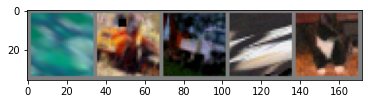

In [47]:
displayimages.show_random_image(trainloader,classes)


In [48]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = deep_cnn.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

/content/drive/My Drive/Colab Notebooks/S9_CIFAR10_Albumentation_GRADCAM/customDeepCNN.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/content/drive/My Drive/Colab Notebooks/S9_CIFAR10_Albumentation_GRADCAM/customDeepCNN.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [50]:
EPOCHS =25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test.train(model, device, trainloader, optimizer, epoch,False)
    train_test.test(model, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


/content/drive/My Drive/Colab Notebooks/S9_CIFAR10_Albumentation_GRADCAM/customDeepCNN.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/content/drive/My Drive/Colab Notebooks/S9_CIFAR10_Albumentation_GRADCAM/customDeepCNN.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=332.7327575683594 Batch_id=390 Accuracy=9.96: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.8331, Accuracy: 1000/10000 (10.00%)

EPOCH: 1


Loss=282.3397521972656 Batch_id=390 Accuracy=10.12: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.2405, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=320.89044189453125 Batch_id=390 Accuracy=10.12: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 3.2894, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=279.38507080078125 Batch_id=390 Accuracy=10.14: 100%|██████████| 391/391 [01:02<00:00,  6.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.6892, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=274.07977294921875 Batch_id=390 Accuracy=10.14: 100%|██████████| 391/391 [01:02<00:00,  6.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.6756, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=314.5213623046875 Batch_id=390 Accuracy=10.05: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.9504, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=430.6048278808594 Batch_id=390 Accuracy=10.27: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 3.7034, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=336.62078857421875 Batch_id=390 Accuracy=9.86: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 3.5112, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=522.2251586914062 Batch_id=390 Accuracy=10.02: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.9529, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=398.12762451171875 Batch_id=390 Accuracy=9.94: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.9576, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=221.6092987060547 Batch_id=390 Accuracy=9.80: 100%|██████████| 391/391 [01:01<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.1696, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=354.01959228515625 Batch_id=390 Accuracy=10.10: 100%|██████████| 391/391 [01:01<00:00,  6.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3314, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Loss=297.95904541015625 Batch_id=390 Accuracy=10.14: 100%|██████████| 391/391 [01:02<00:00,  6.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.8594, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Loss=360.56463623046875 Batch_id=390 Accuracy=9.84: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.5277, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 3.4180, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Loss=203.86398315429688 Batch_id=390 Accuracy=9.93: 100%|██████████| 391/391 [01:02<00:00,  6.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.7712, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Loss=142.09129333496094 Batch_id=390 Accuracy=10.11: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1537, Accuracy: 1000/10000 (10.00%)

EPOCH: 17


Loss=394.47149658203125 Batch_id=390 Accuracy=9.96: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.3709, Accuracy: 1000/10000 (10.00%)

EPOCH: 18


Loss=351.1911926269531 Batch_id=390 Accuracy=9.90: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 3.1352, Accuracy: 1000/10000 (10.00%)

EPOCH: 19


Loss=405.1401062011719 Batch_id=390 Accuracy=9.76: 100%|██████████| 391/391 [01:02<00:00,  6.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.9665, Accuracy: 1000/10000 (10.00%)

EPOCH: 20


Loss=348.9105529785156 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 3.2565, Accuracy: 1000/10000 (10.00%)

EPOCH: 21


Loss=335.26568603515625 Batch_id=390 Accuracy=9.94: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.4507, Accuracy: 1000/10000 (10.00%)

EPOCH: 22


Loss=396.39935302734375 Batch_id=390 Accuracy=9.89: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 2.5276, Accuracy: 1000/10000 (10.00%)

EPOCH: 23


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.8906, Accuracy: 1000/10000 (10.00%)

EPOCH: 24


Loss=341.572265625 Batch_id=390 Accuracy=10.14: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]



Test set: Average loss: 2.2542, Accuracy: 1000/10000 (10.00%)



In [0]:
#source : https://github.com/vickyliin/gradcam_plus_plus-pytorch
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from models.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

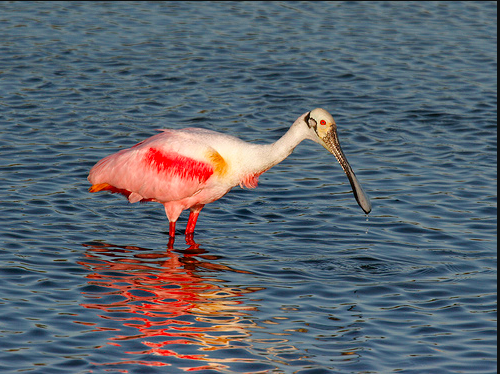

In [52]:
img_dir = 'images'
img_name = 'water-bird.JPEG'
img_path = os.path.join(img_dir, img_name)
# test image has an additional alpha channel per pixel, thus it has 4 channels where instead on only three. convert('RGB') reduces to three

pil_img = PIL.Image.open(img_path).convert('RGB') #test_image = Image.open(test_image_name).convert('RGB')

pil_img

In [0]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
#normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
#torch_img = transforms.Compose([transforms.Resize((56, 56)), transforms.ToTensor()])(pil_img).to(device)
#normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [0]:
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]


In [0]:
#alexnet = models.alexnet(pretrained=True)
#vgg = models.vgg16(pretrained=True)
resnet = models.resnet101(pretrained=True)
#densenet = models.densenet161(pretrained=True)
#squeezenet = models.squeezenet1_1(pretrained=True)

In [0]:
configs = [
    #dict(model_type='alexnet', arch=alexnet, layer_name='features_11'),
    #dict(model_type='vgg', arch=vgg, layer_name='features_29'),
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
    #dict(model_type='densenet', arch=densenet, layer_name='features_norm5'),
    #dict(model_type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation')
]

In [0]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [58]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


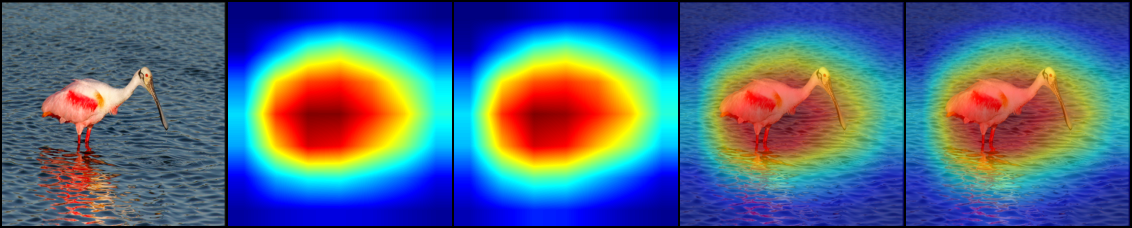

In [59]:
transforms.ToPILImage()(grid_image)
